Note: We ran this notebook on AWS 'g4dn.4xlarge' EC2 instance with Ubuntu's Deep Learning AMI.

# Capstone Project: Skin Lesion Classification and Diagnosis
## Notebook 4a: Modelling and Evaluation for Skin Lesion Classification

### Table of Contents
- [Problem Statement](#Problem-Statement)
- [Importing Libraries](#Importing-Libraries)
- [Functions](#Functions)
- [Metrics](#Metrics)
- [Loading Data](#Loading-Data)
- [Baseline: Artificial Neural Network](#Baseline:-Artificial-Neural-Network)
- [Baseline Model Evaluation](#Baseline-Model-Evaluation)
- [Convolutional Neural Network (CNN) Model](#Convolutional-Neural-Network-(CNN)-Model)
- [CNN Model Evaluation](#CNN-Model-Evaluation)
- [Final Model Evaluation](#Final-Model-Evaluation)
- [Confusion Matrix](#Confusion-Matrix)
- [Classification Metrics](#Classification-Metrics)
- [Studying Wrong Predictions](#Studying-Wrong-Predictions)


### Problem Statement

Skin cancer is the most common cancer globally, with melanoma being the most deadly form. Even though dermoscopy, a skin imaging modality, has demonstrated improvement for the diagnosis of skin cancer compared to unaided visual inspection<sup>[[1]](https://challenge2019.isic-archive.com/)</sup>, numerous cases of benign lesions are still being diagnosed as malicious and vice versa<sup>[[2]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6394090/)</sup>. Every year, poor diagnostic errors adds an estimated $673 million in overall cost to manage the disease<sup>[[3]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543387/)</sup>.

In this project, we aim to improve the diagnosis rate of skin cancer through the classification of skin lesions for dermatologists working at hospitals or skin clinics in Singapore, who will need experience or expertise in diagnosing skin cancer before they can accurately identify and diagnose lesions upon visual and dermoscopy inspection<sup>[[3]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543387/)</sup>. This will be done through the classification of skin lesion dermoscopy images, in which we will predict two important tasks through the usage of Convolutional Neural Network models: <br>
1. a specific skin lesion diagnosis, and <br>
2. whether the lesion is malignant, benign, or pre-cancerous. <br>

The model will be evaluated based on its accuracy, followed by its recall rate since we are looking to minimise false negatives. Ultimately, we aim to get as close to a real evaluation of a dermatologist as possible: predicting the type of skin lesion; and whether the lesion is malignant, pre-cancerous or benign from dermoscopy images. With our models, we hope to aid dermatologists in their decision-making process of diagnosing skin lesions, hence allowing them to improve their diagnostic accuracy and come up with appropriate treatments for patients with skin lesions and/or cancers.

### Importing Libraries

In [1]:
#importing libraries

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score

from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalMaxPooling2D, Activation
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.metrics import top_k_categorical_accuracy
from keras.models import load_model
from keras.models import Sequential
#from keras import backend as K

np.random.seed(32)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Functions

In [4]:
#creating function that plots the history of models (with the history saved as a dataframe)
def plot_graph_from_dataframe(model, metric, metric_name, val_metric_name, baseline=0):
    #Set figure size
    plt.figure(figsize=(8,6))
    #Generate line plot of training, validation metric over epochs
    plt.plot(model[metric], label=metric_name)
    plt.plot(model['val_' + metric], label=val_metric_name)
    
    #Insert baseline if there's any baseline stated
    if baseline>0:
        plt.axhline(y=baseline, linewidth=1, color='r', linestyle = '--', label = 'Baseline')
        
    plt.legend(fontsize=10)
    #Set title
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.title('Training and Validation ' + metric_name + ' by Epoch', fontsize = 12);

In [9]:
#Defining function for plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title, normalize=False, cmap=plt.cm.Blues):

    #compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #convert to percentage if normalize=True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    #We want to show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    #loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Metrics

In [3]:
#run this code for top_2_accuracy metric for modelling

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [8]:
#creating get_recall function that computes overall macro-average recall rate
#and also prints the recall rate for each individual class (if print_ind_classes=True)

def get_recall(y_true, y_pred, classes, no_of_classes, print_ind_classes=False):
    cm = confusion_matrix(y_true, y_pred)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    overall_recall = np.mean(recall)
    
    #only print recall rate for each class if print_ind_classes=True
    if print_ind_classes:
        for x in range(no_of_classes):
            class_recall = recall[x]
            class_name = classes[x]
            print(f"Recall rate for {class_name}: {round(class_recall,4)}")
        print("")
    return overall_recall

In [9]:
#creating get_precision function that computes overall macro-average precision rate
#and also prints the precision rate for each individual class (if print_ind_classes=True)

def get_precision(y_true, y_pred, classes, no_of_classes, print_ind_classes=False):
    cm = confusion_matrix(y_true, y_pred)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    overall_precision = np.mean(precision)
    
    #only print precision rate for each class if print_ind_classes=True
    if print_ind_classes:
        for x in range(no_of_classes):
            class_precision = precision[x]
            class_name = classes[x]
            print(f"Precision rate for {class_name}: {round(class_precision,4)}")
        print("")
        
    return overall_precision

In [10]:
#creating get_f1_score function that computes overall macro-average f1 score
#and also prints the f1 score for each individual class (if print_ind_classes=True)

def get_f1_score(y_true, y_pred, classes, no_of_classes, print_ind_classes=False):
    cm = confusion_matrix(y_true, y_pred)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    
    overall_f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
    
    #only print f1 score for each class if print_ind_classes=True
    if print_ind_classes:
        for x in range(no_of_classes):
            class_precision = precision[x]
            class_recall = recall[x]
            class_name = classes[x]
            class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall)
            print(f"F1 Score for {class_name}: {round(class_f1,4)}")
        print("")
        
    return overall_f1

### Loading data

In [4]:
#download link for X_train: https://mega.nz/file/FF1SHAoC#_oOQI7dsHFni0IG5gOmqmGQ9dUqjgH6z2nLqJSNXEx8
#download link for X_val, X_test: https://drive.google.com/drive/folders/1OQkvKDiSHYP90keb8cVTWOG4bk0xDHjz?usp=sharing

#loading image data for X_train (X_smote) and y_train (y_smote)
X_train = np.load('./datasets/npy/lesion/X_smote_lesion_284.npy')
y_train = np.load('./datasets/npy/lesion/y_smote_lesion_284.npy')

#loading image data for X_val and y_val
X_val = np.load('./datasets/npy/lesion/X_val_lesion_284.npy')
y_val = np.load('./datasets/npy/lesion/y_val_lesion_284.npy')

#loading image data for X_test and y_test
X_test = np.load('./datasets/npy/lesion/X_test_lesion_284.npy')
y_test = np.load('./datasets/npy/lesion/y_test_lesion_284.npy')

In [7]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (20965, 284, 284, 3)
y_train:  (20965, 7)
X_val:  (2055, 284, 284, 3)
y_val:  (2055, 7)
X_test:  (2056, 284, 284, 3)
y_test:  (2056, 7)


## Baseline: Artificial Neural Network

In [19]:
b_model = Sequential()

#input layer
b_model.add(Dense(20, activation='relu', input_shape=X_train.shape[1:]))
b_model.add(Dropout(0.5))

#hidden layer 1
b_model.add(Dense(10, activation='relu'))
b_model.add(Dropout(0.5))

#flatten before putting into output layer
b_model.add(Flatten())

#output later
b_model.add(Dense(7, activation='softmax'))

In [20]:
b_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 284, 284, 20)      80        
_________________________________________________________________
dropout_5 (Dropout)          (None, 284, 284, 20)      0         
_________________________________________________________________
dense_8 (Dense)              (None, 284, 284, 10)      210       
_________________________________________________________________
dropout_6 (Dropout)          (None, 284, 284, 10)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 806560)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 5645927   
Total params: 5,646,217
Trainable params: 5,646,217
Non-trainable params: 0
____________________________________________

In [21]:
b_model.compile(optimizer = Adam(0.0005), #set learning rate of 0.0005
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', top_2_accuracy])         
            #inserting accuracy and top_2_accuracy metric

In [22]:
#run baseline model for 15 epochs at batch size of 32
baseline_model = b_model.fit(X_train, y_train, batch_size=32, 
                      epochs = 15, 
                      validation_data = (X_val, y_val)) 

Train on 20965 samples, validate on 2055 samples
Epoch 1/15
20965/20965 [==============================] - 62s 3ms/step - loss: 6.5397 - accuracy: 0.3256 - top_2_accuracy: 0.5294 - val_loss: 2.2036 - val_accuracy: 0.1562 - val_top_2_accuracy: 0.3971
Epoch 2/15
20965/20965 [==============================] - 66s 3ms/step - loss: 1.3393 - accuracy: 0.5098 - top_2_accuracy: 0.7158 - val_loss: 1.9804 - val_accuracy: 0.2292 - val_top_2_accuracy: 0.4209
Epoch 3/15
20965/20965 [==============================] - 66s 3ms/step - loss: 1.0983 - accuracy: 0.5921 - top_2_accuracy: 0.7838 - val_loss: 1.9475 - val_accuracy: 0.2316 - val_top_2_accuracy: 0.4681
Epoch 4/15
20965/20965 [==============================] - 66s 3ms/step - loss: 0.9210 - accuracy: 0.6696 - top_2_accuracy: 0.8411 - val_loss: 1.6054 - val_accuracy: 0.4136 - val_top_2_accuracy: 0.6574
Epoch 5/15
20965/20965 [==============================] - 66s 3ms/step - loss: 0.7848 - accuracy: 0.7253 - top_2_accuracy: 0.8771 - val_loss: 1.416

In [23]:
#save history to dataframe
nn_model_history =  pd.DataFrame(baseline_model.history)

In [24]:
#export history's dataframe as baseline_model_history
nn_model_history.to_csv('./datasets/history/lesion/baseline_model_history.csv', index=False)

In [25]:
#save model and architecture to single file
b_model.save("./model/lesion_classifier/baseline_model.h5")
print("Saved model to disk")

Saved model to disk


### Baseline Model Evaluation

#### Plotting loss and accuracy over epochs

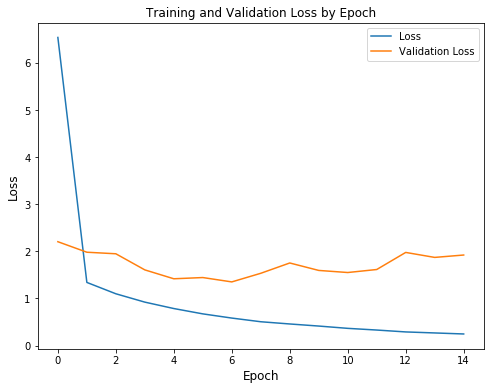

In [26]:
#plot train and validation loss over epoch
plot_graph_from_dataframe(nn_model_history, 'loss', 'Loss', 'Validation Loss')

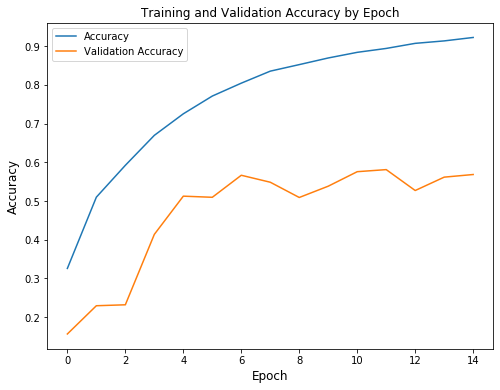

In [27]:
#plot train and validation accuracy over epoch
plot_graph_from_dataframe(nn_model_history, 'accuracy', 'Accuracy', 'Validation Accuracy')

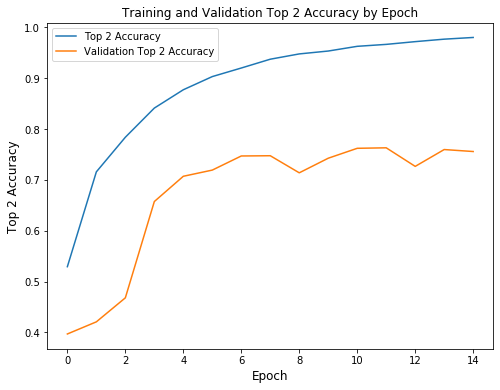

In [28]:
#Plot train and validation top 2 accuracy over epoch
plot_graph_from_dataframe(nn_model_history, 'top_2_accuracy', 'Top 2 Accuracy', 'Validation Top 2 Accuracy')

#### Validation Accuracy and Recall

In [4]:
#load model if required
b_model = load_model('./model/lesion_classifier/baseline_model.h5', 
                    custom_objects={'top_2_accuracy': top_2_accuracy}) 

In [83]:
val_loss, val_accuracy, val_top_2_accuracy = b_model.evaluate(X_val, y_val, verbose=1)

2055/2055 [==============================] - 2s 1ms/step


In [84]:
print('Val Accuracy:', round(val_accuracy,4))
print('Val Top 2 Accuracy:', round(val_top_2_accuracy,4))

Val Accuracy: 0.5684
Val Top 2 Accuracy: 0.7557


In [12]:
#making predictions for validation set
y_pred_val_b = np.argmax(b_model.predict(X_val), axis=-1)
y_true_val_b = np.argmax(y_val, axis=1)

#calculate macro average recall rate for val
val_recall_rate_b = get_recall(y_true_val_b, y_pred_val_b, classes=False, no_of_classes=7, print_ind_classes=False)
print('Val Macro Average Recall Rate:', round(val_recall_rate_b,4))

Val Macro Average Recall Rate: 0.3838


With a validation accuracy of 0.5684, a top 2 accuracy of 0.7557 and a overall recall rate of 0.3838 for our baseline model, we will be setting these scores as our baseline moving forward.

## Convolutional Neural Network (CNN) Model

To get the best-performing model, the complexity of the model was gradually increased and the parameters were tuned for the best performance by looking at the loss and accuracy metrics of the validation data (in relation to the training data). Batch Normalization (BN) layers were added after each convolution layer to not only allow for faster training times, but also also allow for regularisation effects with better model performance.
Though there have been debates on whether the BN layers should be inserted before or after activation layers, the BN layers were eventually inserted before the activation layers in our model, as explained by Ioffe and Szegedy in their paper focusing on BN<sup>[[6]](https://arxiv.org/pdf/1502.03167.pdf)</sup>. 

Dropouts were only utilised after the hidden layer where BN has not been applied, since utilising dropouts after BN has been known to worsen model performance<sup>[[7]](https://arxiv.org/abs/1801.05134)</sup>.
Instead of GlobalAveragePooling2D or Flatten layers, GlobalMaxPooling2D layer was chosen to be inserted before the hidden layer due to slightly better model performance.

ReduceLROnPlateau was also utilised as a callback feature for the model, allowing the model to reduce its learning rate when validation loss has not decrease for a selected number of epochs (5 in the case of our model). A minimum learning rate of 0.00001 was set for this API since setting learning rates below 0.00001 did not appear to improve the model's performance. Since the usage of ReduceLROnPlateau with an initial learning rate of 0.0001 has helped to increase the model performance, we have decided to use this combination for our model.

In [41]:
model = Sequential()

#Input layer: Convolution layer 1 with padding
model.add(Conv2D(filters=16, kernel_size=(5, 5), padding = 'same', input_shape=(284,284,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Convolution layer 2
model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Convolution layer 3
model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Convolution layer 4
model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#BN and GlobalMaxPooling2D before putting it into hidden layer
model.add(BatchNormalization())
model.add(GlobalMaxPooling2D())

#Hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

#Output layer
model.add(Dense(7, activation='softmax'))

In [42]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 284, 284, 16)      1216      
_________________________________________________________________
batch_normalization_6 (Batch (None, 284, 284, 16)      64        
_________________________________________________________________
activation_5 (Activation)    (None, 284, 284, 16)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 142, 142, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 140, 140, 32)      4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 140, 140, 32)      128       
_________________________________________________________________
activation_6 (Activation)    (None, 140, 140, 32)     

In [43]:
#utilising ReduceLROnPlateau, with factor if 0.1 if val_loss stops decreasing for 5 epochs
#minimum learning rate the model can decrease to is 0.00001
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [44]:
#utilising ModelCheckpoint to get best weights
filepath="./weights/lesion/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [45]:
model.compile(optimizer=Adam(lr=0.0001), #set learning rate of 0.0001
                loss='categorical_crossentropy', 
                metrics=['accuracy', top_2_accuracy])         
                #inserting accuracy and top_2_accuracy metric for model evaluation later

In [46]:
#run it for 25 epochs with batch size of 32
cnn_model = model.fit(X_train, y_train, 
                      batch_size = 32, 
                      epochs = 25,
                      validation_data = (X_val, y_val),
                      callbacks=[rlrop, checkpoint]) 

Train on 20965 samples, validate on 2055 samples
Epoch 1/25
20965/20965 [==============================] - 99s 5ms/step - loss: 1.7154 - accuracy: 0.4179 - top_2_accuracy: 0.6072 - val_loss: 1.3580 - val_accuracy: 0.5022 - val_top_2_accuracy: 0.6983

Epoch 00001: val_accuracy improved from -inf to 0.50219, saving model to ./weights/lesion/weights-improvement-01-0.50.hdf5
Epoch 2/25
20965/20965 [==============================] - 98s 5ms/step - loss: 1.2201 - accuracy: 0.5430 - top_2_accuracy: 0.7424 - val_loss: 1.0828 - val_accuracy: 0.6049 - val_top_2_accuracy: 0.7762

Epoch 00002: val_accuracy improved from 0.50219 to 0.60487, saving model to ./weights/lesion/weights-improvement-02-0.60.hdf5
Epoch 3/25
20965/20965 [==============================] - 98s 5ms/step - loss: 1.0861 - accuracy: 0.5954 - top_2_accuracy: 0.7890 - val_loss: 1.0637 - val_accuracy: 0.6049 - val_top_2_accuracy: 0.7757

Epoch 00003: val_accuracy did not improve from 0.60487
Epoch 4/25
20965/20965 [=================

In [47]:
#save history to dataframe
cnn_model_history =  pd.DataFrame(cnn_model.history)

In [48]:
#export as csv
cnn_model_history.to_csv('./datasets/history/lesion/4a_cnn_model_smote_history.csv', index=False)

In [49]:
#save model and architecture to single file
model.save("./model/lesion_classifier/4a_cnn_smote_model_1.h5")
print("Saved model to disk")

Saved model to disk


### CNN Model Evaluation

#### Plotting loss and accuracy over epochs

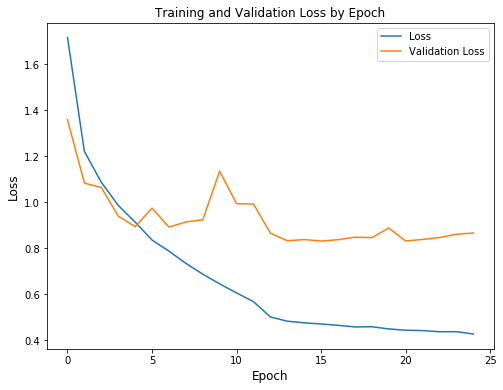

In [50]:
#plotting train and validation loss over epochs
plot_graph_from_dataframe(cnn_model_history, 'loss', 'Loss', 'Validation Loss')

Text(0.5, 1.0, 'Learning Rate by Epoch')

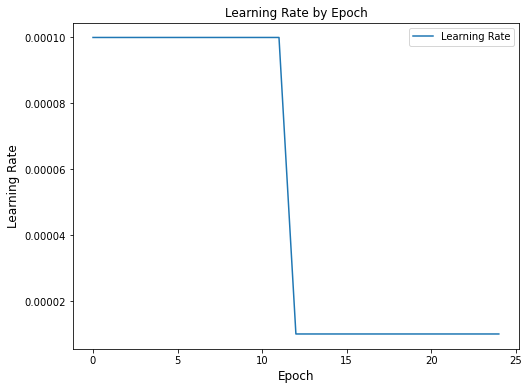

In [6]:
#Plot learning rate over epoch to see if it changes

#set figure size
plt.figure(figsize=(8,6))
#Generate line plot learning rate epochs
plt.plot(cnn_model_history['lr'], label='Learning Rate')
plt.legend(fontsize=10)
#Set title
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('Learning Rate by Epoch', fontsize = 12)

As seen above, the validation loss seems to be increasing at first (from 5th to 10th epoch) before decreasing significantly at the 13th epoch and reaching a plateau at around 0.86. The sudden decrease in validation loss at the 10th epoch happened because the learning rate decreased by a factor of 0.1 (from the graph shown above) due to the usage of ReduceLROnPlateau.
As for the training loss curve, it seems to drop before reaching a plateau of 0.44

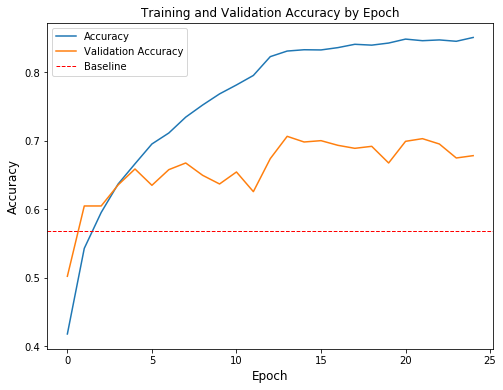

In [55]:
#plotting train and validation accuracy over epochs
#with baseline accuracy of 0.5684 from baseline model
plot_graph_from_dataframe(cnn_model_history, 'accuracy', 'Accuracy', 'Validation Accuracy', 0.5684)

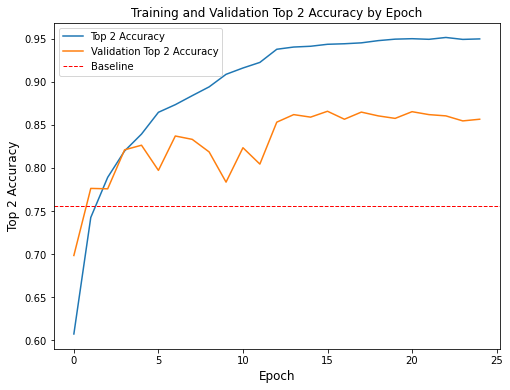

In [16]:
#plotting train and validation top 2 accuracy over epochs
#with baseline accuracy of 0.7557 from baseline model
plot_graph_from_dataframe(cnn_model_history, 'top_2_accuracy', 'Top 2 Accuracy',
                          'Validation Top 2 Accuracy', 0.7557)

#### Validation Accuracy and Recall

In [13]:
#load model if required
model = load_model('./model/lesion_classifier/4a_cnn_smote_model_1.h5', 
                    custom_objects={'top_2_accuracy': top_2_accuracy}) 

In [14]:
#loading our model's best weights
model.load_weights("./weights/lesion/weights-improvement-14-0.71.hdf5")

In [58]:
val_loss, val_accuracy, val_top_2_accuracy = model.evaluate(X_val, y_val, verbose=1)

2055/2055 [==============================] - 3s 1ms/step


In [22]:
print('Val Accuracy:', round(val_accuracy,4))
print('Val Top 2 Accuracy:', round(val_top_2_accuracy,4))

Val Accuracy: 0.7066
Val Top 2 Accuracy: 0.8618


In [15]:
#making predictions for validation set
y_pred_val = np.argmax(model.predict(X_val), axis=-1)
y_true_val = np.argmax(y_val, axis=1)

#calculate recall for val
val_recall_rate = get_recall(y_true_val, y_pred_val, classes=False, no_of_classes=7, print_ind_classes=False)
print('Val\'s Macro Average Recall Rate:', round(val_recall_rate,4))

Val's Macro Average Recall Rate: 0.5773


With a validation accuracy of 0.7066, top 2 accuracy of 0.8618 and a overall recall rate of 0.5773, all 3 metrics have surpassed our baseline score of 0.5684, 0.7557 and 0.3838 for accuracy, top 2 accuracy and recall rate respectively.

## Final Model Evaluation

### Test Accuracy and Recall

In [65]:
test_loss, test_accuracy, test_top_2_accuracy = model.evaluate(X_test, y_test, verbose=1)

2056/2056 [==============================] - 3s 1ms/step


In [20]:
print('Test Accuracy:', round(test_accuracy,4))
print('Test Top 2 Accuracy:', round(test_top_2_accuracy,4))

Test Accuracy: 0.7053
Test Top 2 Accuracy: 0.8624


In [16]:
#Making predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=1)

In [17]:
#calculate recall for test set
test_recall_rate = get_recall(y_true, y_pred, classes=False, no_of_classes=7, print_ind_classes=False)
print('Test\'s Macro Average Recall Rate:', round(test_recall_rate,4))

Test's Macro Average Recall Rate: 0.6068


In [23]:
print('Difference between Test and Validation Accuracy:', abs(round(test_accuracy - val_accuracy,4)))
print('Difference between Test and Validation Top 2 Accuracy:', abs(round(test_top_2_accuracy - val_top_2_accuracy,4)))
print('Difference between Test and Validation Macro Average Recall Rate:', abs(round(test_recall_rate - val_recall_rate,4)))

Difference between Test and Validation Accuracy: 0.0013
Difference between Test and Validation Top 2 Accuracy: 0.0006
Difference between Test and Validation Macro Average Recall Rate: 0.0296


With a very small difference in accuracy and recall rates derived from our test and validation sets (0.0013 for accuracy, 0.0006 for Top 2 Accuracy and 0.0296 for recall), this means that our model generalises well on our test set when compared to our validation set.

### Confusion Matrix

In [25]:
#list down all class names
class_names=['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']

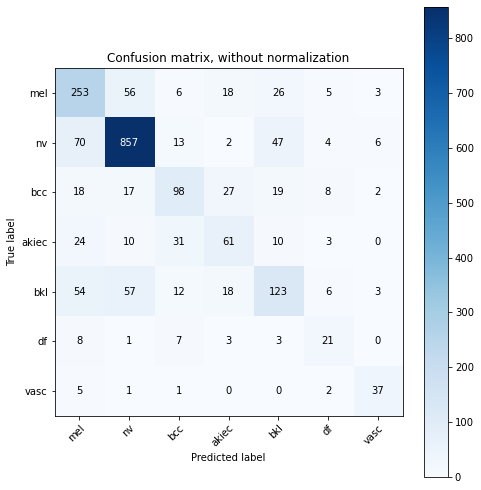

In [31]:
#Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names,title = 'Confusion matrix, without normalization')

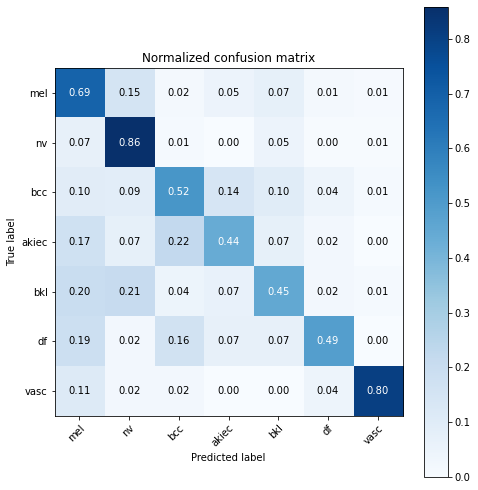

In [32]:
# Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')

Our confusion matrix above illustrates that the classes with lower percentage of accurate predictions are BCC, AKIEC, BKL, and DF. Each class and their top 2 wrongly predicted classes are listed as follows:

|Class|Right Predictions|1st Misclassified Class|Percentage|2nd Misclassified Class|Percentage|
|:---|:---:|:---:|:---:|:---:|:---:|
|**BCC**|52%|AKIEC|14%|MEL|10%|
|**AKIEC**|44%|BCC|2%|AKIEC|17%|
|**BKL**|45%|NV|21%|MEL|20%|
|**DF**|49%|MEL|19%|BCC|16%|

A subset of the wrong predictions from these 4 classes will be plotted and studied below under [Studying Wrong Predictions](#Studying-Wrong-Predictions).

### Classification Metrics

In [34]:
#to access values in the classification report
classification_dict = classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

#print classification report
classification = classification_report(y_true, y_pred, target_names=class_names, digits = 4)
print(classification)

              precision    recall  f1-score   support

         mel     0.5856    0.6894    0.6333       367
          nv     0.8579    0.8579    0.8579       999
         bcc     0.5833    0.5185    0.5490       189
       akiec     0.4729    0.4388    0.4552       139
         bkl     0.5395    0.4505    0.4910       273
          df     0.4286    0.4884    0.4565        43
        vasc     0.7255    0.8043    0.7629        46

    accuracy                         0.7053      2056
   macro avg     0.5990    0.6068    0.6008      2056
weighted avg     0.7038    0.7053    0.7029      2056



Let's study each of our classification metrics in further detail.

#### Accuracy rate

In [34]:
#get accuracy
acc_score = accuracy_score(y_true, y_pred)
print('Accuracy Score:', round(acc_score,4))

Accuracy Score: 0.7053


With a relatively high accuracy score of 0.7053, this means that our model managed to predict 70.53% of predictions correctly (from our test dataset) for our skin lesion classification task.

#### Recall rate

In [39]:
#get individual classes and macro-averaged recall rate
recall = get_recall(y_true, y_pred, class_names, 7, print_ind_classes=True)
print("Overall Macro Average Recall rate:", round(recall,4))

#print weighted recall rate
print("Overall Weighted Recall Rate:", round(classification_dict['weighted avg']['recall'], 4))

Recall rate for mel: 0.6894
Recall rate for nv: 0.8579
Recall rate for bcc: 0.5185
Recall rate for akiec: 0.4388
Recall rate for bkl: 0.4505
Recall rate for df: 0.4884
Recall rate for vasc: 0.8043

Overall Macro Average Recall rate: 0.6068
Overall Weighted Recall Rate: 0.7053


A higher recall rate minimises the false negatives (type II error), since the recall rate computes the fraction of examples which were predicted to belong to a class (true positives) with respect to all of the examples that truly belong in the class (true positive and false negatives). 

With an average recall rate of 0.6068, this means that the model predicts close to 4 false negatives per 10 predictions. A higher percentage of false negatives are mostly from 4 minority classes (BCC, AKIEC, BKL, and DF), since with their individual recall rates are all below 0.52. These four classes, especially AKIEC and BKL, are mostly known to appear in different variants with regards to their shapes and colours that mimic other skin lesions<sup>[[4]](https://arxiv.org/pdf/1803.10417.pdf)</sup>, which can explain the reason behind higher false negatives for these minority classes.

However, the recall rates for the rest of the classes are all much higher, with the lowest recall rate at 0.6894 for MEL, VASC at 0.8043 and the highest at 0.8579 for the majority class NV. Unsurprisingly, the two skin lesion classes that surpass a recall rate of 0.80 are VASC and NV since these two classes are particularly are known to have more a uniform distribution with regards to their colour and structure.

The recall rates for each lesion mostly corresponds with studies that were done on a similar classification task, with one particular study getting a very similar macro average recall score of 0.6043<sup>[[8]](https://arxiv.org/pdf/1907.03220.pdf)</sup>.

With regards to the weighted recall rate, the score is relatively high at 0.7053 since more weightage is given to the majority class.

#### Precision rate

In [37]:
#get individual classes and macro-averaged precision rate
precision = get_precision(y_true, y_pred, class_names, 7, print_ind_classes=True)
print("Overall Average Precision rate:", round(precision,4))

#print weighted precision rate
print("Overall Weighted Precision rate:", round(classification_dict['weighted avg']['precision'],4))

Precision rate for mel: 0.5856
Precision rate for nv: 0.8579
Precision rate for bcc: 0.5833
Precision rate for akiec: 0.4729
Precision rate for bkl: 0.5395
Precision rate for df: 0.4286
Precision rate for vasc: 0.7255

Overall Average Precision rate: 0.599
Overall Weighted Precision rate: 0.7038


Similarly, a higher precision rate minimises the false positives (type I error), since the recall rate computes the fraction of relevant examples (true positives) among all of the examples which were predicted to belong in a certain class (true positive and false positives).

With an average precision rate of 0.599, this means that the model predicts close to 4 false positives per 10 predictions. A higher percentage of false positives are also mostly from 5 minority classes (MEL, BCC, AKIEC, BKL, DF), since their individual precision rates are all below 59% (ranging from 0.4286 to 0.5856).
Similarly, both VASC and NV classes have the highest precision rates among all 7 classes, with 0.7255 for VASC and 0.8579 for NV.

Similarly, the precision rates for each class corresponds with studies that were done on a similar classification task, with one study getting a very similar macro average precision score of 0.5829<sup>[[8]](https://arxiv.org/pdf/1907.03220.pdf)</sup>.

On the other hand, the weighted precision rate is relatively high at 0.7038 since more weightage is given to the majority class.

#### F1 Score

In [38]:
#get individual classes and macro-averaged f1 score
f1_score = get_f1_score(y_true, y_pred, class_names, 7, print_ind_classes=True)
print("Overall Macro Average F1 score:", round(f1_score,4))

#print weighted f1 score
print("Overall Weighted F1 score:", round(classification_dict['weighted avg']['f1-score'], 4))

F1 Score for mel: 0.6333
F1 Score for nv: 0.8579
F1 Score for bcc: 0.549
F1 Score for akiec: 0.4552
F1 Score for bkl: 0.491
F1 Score for df: 0.4565
F1 Score for vasc: 0.7629

Overall Macro Average F1 score: 0.6029
Overall Weighted F1 score: 0.7029


The F1 score is defined as the harmonic mean of the model’s precision and recall. With both precision and recall having similar scores, our model's F1 score is at 0.6029. Similarly the F1 scores for the four minority classes are lower, with F1 scores all above 55% for each class, while the f1 score for the better-performing classes (MEL, VASC and NV) are higher at 0.6333, 0.7629 and 0.8579 respectively.

The F1 scores for each class exceeds the scores derived from studies that were done on a similar classification task, with one study getting a lower macro average F1 score of 0.5229<sup>[[8]](https://arxiv.org/pdf/1907.03220.pdf)</sup>.

Similar to the two metrics above, the weighted F1 score is relatively high at 0.7029 since more weightage is given to the majority class.

#### Cohen Kappa Score

In [38]:
#get cohen kappa score
cohen = cohen_kappa_score(y_true, y_pred)
print("Kappa Score:", round(cohen,4))

Kappa Score: 0.5783


With scores between 1 and 0, the Kappa Score measures the degree of agreement between the true values and predicted values with 1 representing perfect agreement and 0 representing chance agreement. This measure computes how much better our classifier is performing over the performance of a classifier that simply guesses at random according to the frequency of each class<sup>[[9]](https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c)</sup>. 

Our model has a kappa score of 0.5783, which means that our classifier model has moderate agreement between the true values and predicted values<sup>[[10]](https://thedatascientist.com/performance-measures-cohens-kappa-statistic/)</sup> and performs moderately well as a classifier.

### Studying Wrong Predictions

Let's study some of the wrong predictions made for the top 4 worst-performing classes (BCC, AKIEC, BKL and DF).

In [47]:
#creating dataframe of predictions against actual label
predictions = [x for x in y_pred]
true_values = [x for x in y_true]

pred = pd.DataFrame(list(zip(predictions,true_values)), columns = ['predictions', 'actual_label'])
pred.head(5)

,predictions,actual_label
0,4,4
1,0,0
2,1,4
3,4,2
4,1,1


In [48]:
#exporting pred as lesion_pred.csv
pred.to_csv('./datasets/lesion_pred.csv', index=False)

In [43]:
#convert their values to their respective class
pred.actual_label = pred.actual_label.map({0: 'mel', 1: 'nv', 2:'bcc', 3: 'akiec', 4: 'bkl', 5: 'df', 6: 'vasc'})
pred.predictions = pred.predictions.map({0: 'mel', 1: 'nv', 2:'bcc', 3: 'akiec', 4: 'bkl', 5: 'df', 6: 'vasc'})
pred.head(5)

,predictions,actual_label
0,bkl,bkl
1,mel,mel
2,nv,bkl
3,bkl,bcc
4,nv,nv


In [44]:
#wrong mel and akiec predictions for bcc class
bcc_as_mel = pred[(pred['actual_label'] == 'bcc') & (pred['predictions']=='mel')]
bcc_as_akiec = pred[(pred['actual_label'] == 'bcc') & (pred['predictions']=='akiec')]

#wrong mel and bcc predictions for akiec class
akiec_as_bcc = pred[(pred['actual_label'] == 'akiec') & (pred['predictions']=='bcc')]
akiec_as_mel = pred[(pred['actual_label'] == 'akiec') & (pred['predictions']=='mel')]

#wrong mel and nv predictions for bkl class
bkl_as_mel = pred[(pred['actual_label'] == 'bkl') & (pred['predictions']=='mel')]
bkl_as_nv = pred[(pred['actual_label'] == 'bkl') & (pred['predictions']=='nv')]

#wrong mel and bcc predictions for df class
df_as_mel = pred[(pred['actual_label'] == 'df') & (pred['predictions']=='mel')]
df_as_bcc = pred[(pred['actual_label'] == 'df') & (pred['predictions']=='bcc')]

#### BCC

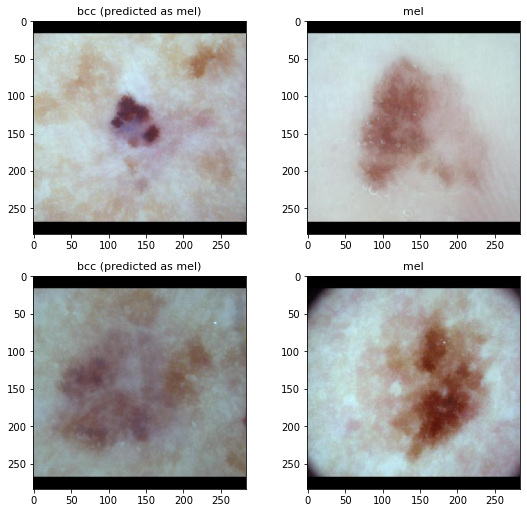

In [57]:
#plot images showing bcc lesions being predicted as mel
plt.figure(figsize = (9,18))
count = 1
for i in range(2):
    index = bcc_as_mel.index[i+2]
    plt.subplot(4,2, count)
    plt.imshow(X_test[index])
    plt.title('bcc (predicted as mel)', fontsize=11)

    index_1 = pred[pred['actual_label'] == 'mel'].index[i]
    plt.subplot(4,2, count+1)
    plt.imshow(X_test[index_1])
    plt.title('mel', fontsize=11)
    
    count = count + 2

As seen above, some of the BCC lesions that are misclassified as MEL do share similar colour and even shape characteristics, hence can explain why several BCC images can be misclassified as MEL to a certain extent.

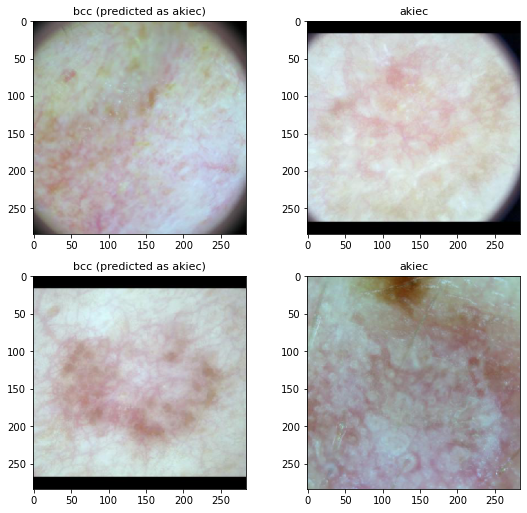

In [63]:
#plot images showing bcc lesions being predicted as akiec
plt.figure(figsize = (9,18))
count = 1
for i in range(2):
    index = bcc_as_akiec.index[i+2]
    plt.subplot(4,2, count)
    plt.imshow(X_test[index])
    plt.title('bcc (predicted as akiec)', fontsize=11)

    index_1 = pred[pred['actual_label'] == 'akiec'].index[i+2]
    plt.subplot(4,2, count+1)
    plt.imshow(X_test[index_1])
    plt.title('akiec', fontsize=11)
    
    count = count + 2

Similarly, the bcc lesions that are predicted as AKIEC also share similar colour and pattern characteristics with true AKIEC lesions.

#### AKIEC

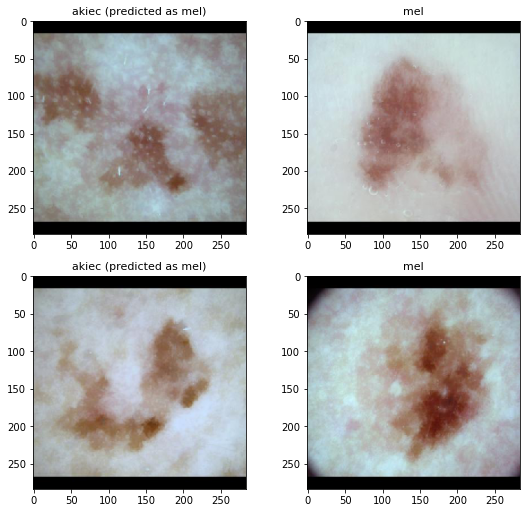

In [65]:
#plot images showing akiec lesions being predicted as mel
plt.figure(figsize = (9,18))
count = 1
for i in range(2):
    index = akiec_as_mel.index[i]
    plt.subplot(4,2, count)
    plt.imshow(X_test[index])
    plt.title('akiec (predicted as mel)', fontsize=11)

    index_1 = pred[pred['actual_label'] == 'mel'].index[i]
    plt.subplot(4,2, count+1)
    plt.imshow(X_test[index_1])
    plt.title('mel', fontsize=11)
    
    count = count + 2

Since most of the MEL lesions from our dataset are highly pigmented<sup>[[4]](https://arxiv.org/pdf/1803.10417.pdf)</sup> as shown above, this explains why several AKIEC pigmented lesions as seen above are wrongly predicted as MEL.

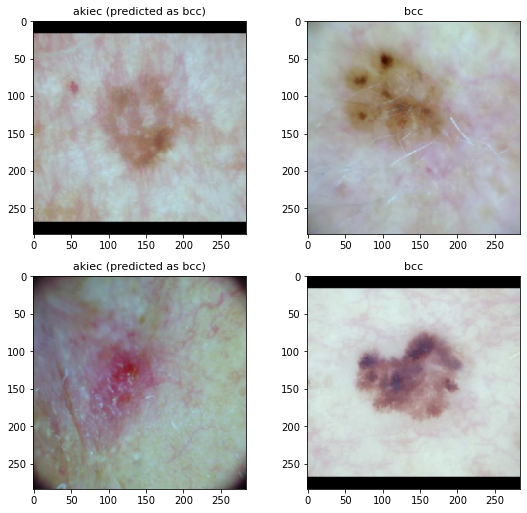

In [72]:
#plot images showing akiec lesions being predicted as bcc
plt.figure(figsize = (9,18))
count = 1
for i in range(2):
    index = akiec_as_bcc.index[i]
    plt.subplot(4,2, count)
    plt.imshow(X_test[index])
    plt.title('akiec (predicted as bcc)', fontsize=11)

    index_1 = pred[pred['actual_label'] == 'bcc'].index[i+3]
    plt.subplot(4,2, count+1)
    plt.imshow(X_test[index_1])
    plt.title('bcc', fontsize=11)
    
    count = count + 2

On the other hand, AKIEC lesions that misclassified as BCC lesions do share some common characteristics with true BCC lesions: faint red streaks on the skin around the lesion and the colour of the lesion to a certain extent.

#### BKL

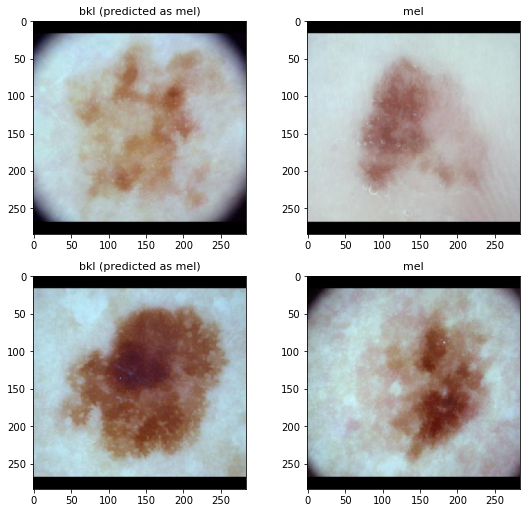

In [75]:
#plot images showing bkl lesions being predicted as mel
plt.figure(figsize = (9,18))
count = 1
for i in range(2):
    index = bkl_as_mel.index[i+2]
    plt.subplot(4,2, count)
    plt.imshow(X_test[index])
    plt.title('bkl (predicted as mel)', fontsize=11)

    index_1 = pred[pred['actual_label'] == 'mel'].index[i]
    plt.subplot(4,2, count+1)
    plt.imshow(X_test[index_1])
    plt.title('mel', fontsize=11)
    
    count = count + 2

One of the subgroups of BKL, lichen-planus like keratoses (LPLK), can show morphologic features that mimic MEL<sup>[[4]](https://arxiv.org/pdf/1803.10417.pdf)</sup> as evident by the plot above. Hence, this does explain why several BKL lesions (in particular, LPLK) can be misclassified as MEL. 

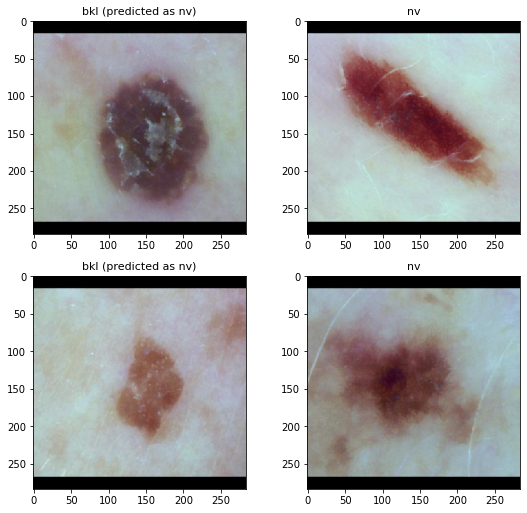

In [78]:
#plot images showing bkl lesions being predicted as nv
plt.figure(figsize = (9,18))
count = 1
for i in range(2):
    index = bkl_as_nv.index[i]
    plt.subplot(4,2, count)
    plt.imshow(X_test[index])
    plt.title('bkl (predicted as nv)', fontsize=11)

    index_1 = pred[pred['actual_label'] == 'nv'].index[i+1]
    plt.subplot(4,2, count+1)
    plt.imshow(X_test[index_1])
    plt.title('nv', fontsize=11)
    
    count = count + 2

Similarly, the colour characteristics of BKL lesions being misclassified as NV are also similar to a certain extent.

#### DF

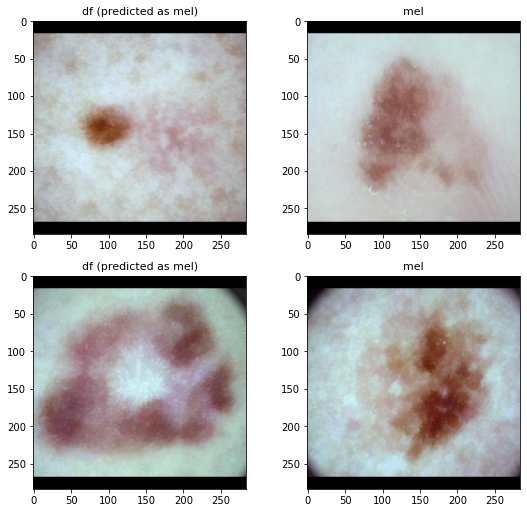

In [80]:
#plot images showing df lesions being predicted as mel
plt.figure(figsize = (9,18))
count = 1
for i in range(2):
    index = df_as_mel.index[i]
    plt.subplot(4,2, count)
    plt.imshow(X_test[index])
    plt.title('df (predicted as mel)', fontsize=11)

    index_1 = pred[pred['actual_label'] == 'mel'].index[i]
    plt.subplot(4,2, count+1)
    plt.imshow(X_test[index_1])
    plt.title('mel', fontsize=11)
    
    count = count + 2

Once again, DF lesions that are being misclassified as MEL are highly pigmented, with similar colours to true MEL lesions.

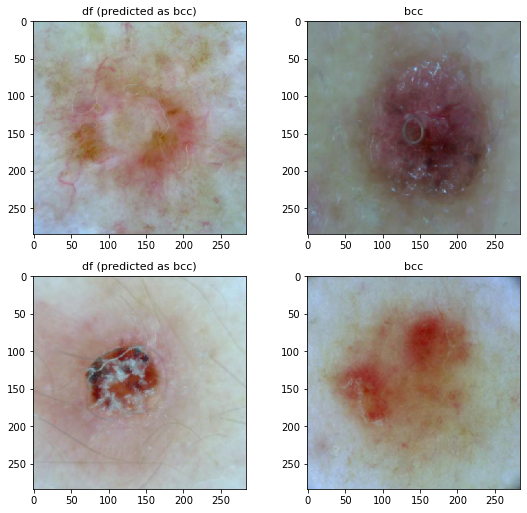

In [45]:
#plot images showing df lesions being predicted as bcc
plt.figure(figsize = (9,18))
count = 1
for i in range(2):
    index = df_as_bcc.index[i+1]
    plt.subplot(4,2, count)
    plt.imshow(X_test[index])
    plt.title('df (predicted as bcc)', fontsize=11)

    index_1 = pred[pred['actual_label'] == 'bcc'].index[i+6]
    plt.subplot(4,2, count+1)
    plt.imshow(X_test[index_1])
    plt.title('bcc', fontsize=11)
    
    count = count + 2

Similarly, DF lesions wrongly predicted as BCC lesions do share some similar shape, pattern and colour-related characteristics.

Comparing the misclassified images with images from their respective wrongly predicted classes, it is apparent that the images of misclassified skin lesions share several similarities with images from the wrongly predicted class. For example, in the case of the images that were misclassified as mel, the morphologic features of most misclassified lesions do share resemblance with the morphologic features of true mel lesions in this dataset.
